<a href="https://colab.research.google.com/github/1o0ko/gan-kata/blob/master/PLinML%20-%201D%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install torch torchvision

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple
from scipy.stats import norm

In [0]:


class Gaussian:
    def __init__(self, mu: float = 0, sigma: float = 1, d: int = 1):
        self.mu = mu
        self.sigma = sigma
        self.d = d

    def sample(self, N: int, sort: bool = True) -> np.ndarray :
        sample = np.random.normal(self.mu, self.sigma, size=(N, self.d))
        
        if sort:
          sample.sort(axis=0)
        
        return sample.reshape(N, self.d)


class Noise(object):
    def __init__(self, domain: Tuple[float], scale: float = 0.01):
        self.domain = domain
        self.scale = scale

    def sample(self, N: int) -> np.ndarray:
        ''' Samples from the Noise distribution

        Use stratified sampling to obtain sorted uniform numbers:
          - generate M equally spaced points within specified range 
          - randomly jitter the points 
        '''
        sample = np.linspace(*self.domain, N)
        sample += np.random.random(N) * self.scale

        return sample.reshape(-1, 1)

In [0]:
mu, sigma =  -1, 1
domain = (-5, 5)

g = Gaussian(mu, sigma, d=1)
z = Noise(domain)

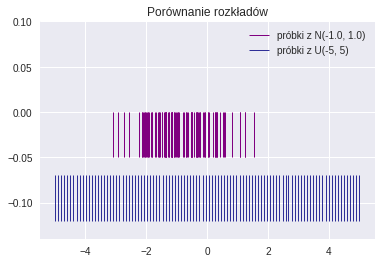

In [5]:
#@title
# Samples
N = 100
B = 10

xs = np.linspace(*domain, N)
g_samples = g.sample(N)
z_samples = z.sample(N)

# Plot distributions 
m = 0.02
plt.vlines(g_samples, ymin=-0.05,    ymax=-0.0,      color='purple', linewidth = 1, label='próbki z N(%.1f, %.1f)' % (mu, sigma));
plt.vlines(z_samples, ymin=-0.1 - m, ymax=-0.05 - m, color='navy', linewidth = 1, label='próbki z U(%d, %d)' % domain, alpha=.8);

# Make it pretty


plt.ylim(top=0.1, bottom = -0.1 - 2*m);
plt.title('Porównanie rozkładów');
plt.legend() ;

In [0]:
#@title
from typing import List, Optional
from math import ceil, floor
from matplotlib import animation

def plot_densities(dist: Gaussian, n_samples: int = 256,
                   samples: Optional[np.ndarray] = None,
                   scores: Optional[np.ndarray] = None,
                   domain: Optional[Tuple[float]] = None,
                   m: float = 0.01, 
                   B: int = 10,
                   title: str = 'GAN vs 1D Gaussian'
                  ):
    # Samples
    if samples is None:
        samples = dist.sample(n_samples)
        
    plt.vlines(samples, ymin=-0.05, ymax=-0.0, color='purple', linewidth = 1, 
               label=f"samples ~ N({dist.mu}, {dist.sigma})");

    # Plot the generated distribution
    ## True density
    if not domain:
      domain = (floor(dist.mu - 3*dist.sigma), ceil(dist.mu + 3*dist.sigma))
      
    
    xs = np.linspace(*domain, n_samples)
    plt.plot(xs, norm.pdf(xs, loc=dist.mu, scale=dist.sigma), 
             'r-', color='violet', alpha=0.6,
             label=f"Density N({dist.mu}, {dist.sigma})")

    ## Empirical density
    bins = np.linspace(*domain, B)
    hist, _ = np.histogram(samples, bins = B, density=True, range=domain)
    
    plt.plot(bins, hist, 
             '.--', color='purple', 
             label=f"Est. denisty N({dist.mu}, {dist.sigma})");
    
    ## Discriminator values
    if scores is not None:
      xs = np.linspace(*domain, n_samples)
      plt.plot(xs, scores, alpha=0.8, label='Discriminator values')

    # Make it pretty

    plt.ylim(top=1.2, bottom = -0.1 - 2*m)
    plt.xlim(xmin=domain[0]*1.1, xmax=domain[-1]*1.1)
    plt.title(title)
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend() 



def samples(
    G, D,
    fixed_noise: np.ndarray,
    dist: Gaussian,
    domain: Optional[Tuple[float]] = None,
    bins: int = B):
    '''
    Return a tuple (db, pd, pg), where db is the current decision
    boundary, pd is a histogram of samples from the data distribution,
    and pg is a histogram of generated samples.
    '''
    
    if not domain:
      domain = (floor(dist.mu - 3*dist.sigma), ceil(dist.mu + 3*dist.sigma))
      
    # shared xs
    xs = np.linspace(*domain, len(fixed_noise))

    # D scores
    s = D(Tensor(xs.reshape(-1, 1))).detach().numpy()

    # data distribution
    d = norm.pdf(xs, loc=dist.mu, scale=dist.sigma)
    
    # generated samples
    samples = G(Tensor(fixed_noise)).detach().numpy()
    g, _ = np.histogram(samples, bins=bins, density=True, range=domain)

    return s, d, g, domain
  

def save_animation(
    anim_path:str,
    anim_frames: List[Tuple[np.ndarray]]):
    '''
    Saves animation of the training process
    '''
    s, d, g, domain = anim_frames[0]
    
    
    f, ax = plt.subplots()
    f.suptitle('GAN vs 1D Gaussian', fontsize=15)
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    
    ax.set_xlim(1.1*domain[0], 1.1*domain[-1])
    ax.set_ylim(-0.12, 1.2)
    
    line_s, = ax.plot([], [], label='Discriminator values')
    line_d, = ax.plot([], [], 'r-', label='True density', color='violet', alpha=0.6)
    line_g, = ax.plot([], [], '.--', color='purple', label='Generated data')

    frame_number = ax.text(
        0.02,
        0.06,
        '',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
    )
    ax.legend()

    
    s_x = np.linspace(*domain, len(s))
    d_x = np.linspace(*domain, len(d))
    g_x = np.linspace(*domain, len(g))
    

    def init():
        line_s.set_data([], [])
        line_d.set_data([], [])
        line_g.set_data([], [])
        
        frame_number.set_text('')
        return (line_s, line_d, line_g, frame_number)

    def animate(i):
        frame_number.set_text(
            'Frame: {}/{}'.format(i, len(anim_frames))
        )
        s, d, g, _ = anim_frames[i]
        line_s.set_data(s_x, s)
        line_d.set_data(d_x, d)
        line_g.set_data(g_x, g)
        
        return (line_s, line_d, line_g, frame_number)

    anim = animation.FuncAnimation(
        f,
        animate,
        init_func=init,
        frames=len(anim_frames),
        blit=True
    )
    anim.save(anim_path, fps=2, extra_args=['-vcodec', 'libx264'])

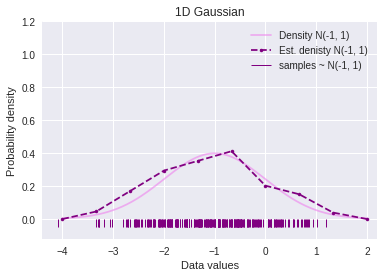

In [7]:
plot_densities(g, title='1D Gaussian')

# Generative Adversarial Network

In [0]:
import torch
import torch.nn as nn

from torch import Tensor


def init_weights(module):
    ''' initializes the weights '''
    for name, param in module.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0.0)
        elif 'weight' in name:
            nn.init.xavier_normal_(param)


class Generator(nn.Module):
    def __init__(self, 
                 input_dim: int = 1, 
                 hidden_dim: int = 32, 
                 output_dim: int = 1):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
          nn.Linear(input_dim, hidden_dim, bias=True), nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim, bias=True), nn.ReLU(),
          nn.Linear(hidden_dim, output_dim, bias=True)
        )
        self.apply(init_weights)
    
    def forward(self, x: Tensor) -> Tensor:
      '''
      Arguments:
        x - 2D tensor of shape B x 1
      
      Returns:
        2D tensor of shape B x 1 with transformed samples
      '''
      return self.net(x)

    
class Discriminator(nn.Module):
    def __init__(self, 
                 input_dim: int = 1, 
                 hidden_dim: int = 32, 
                 output_dim: int = 1):
        super(Discriminator, self).__init__()
        
        # 1 -> 8 -> 1 in (0, 1)
        self.net = nn.Sequential(
          nn.Linear(input_dim, hidden_dim, bias=True),  nn.ReLU(),
          nn.Linear(hidden_dim, output_dim, bias=True), nn.Sigmoid()
        )
     
        self.apply(init_weights)
      
    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
        
      

# Optimalization

$$
\min_G \max_D V(D, G) = 
 \mathbb{E}_{x \sim p_{data}(x)}[\log(D(x))] + 
 \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

In [0]:
def target(value: int, batch_size:int , device='cpu') -> Tensor:
    '''
    Tensor containing target value, with shape = (batch_size, )
    '''
    return torch.full((batch_size, 1), value, device=device)

In [0]:
import torch.optim as optim
from torch.autograd import Variable

batch_size = 256
num_epochs = 3000
epochs_per_frame = 60

# Distributions
mu, sigma = -1.0, 1
g = Gaussian(mu, sigma)
latent = Noise((-4, 2))

# Models
G = Generator(hidden_dim=8)
D = Discriminator(hidden_dim=32)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
G.to(device)
D.to(device)

# Loss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
lr = 0.001   # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

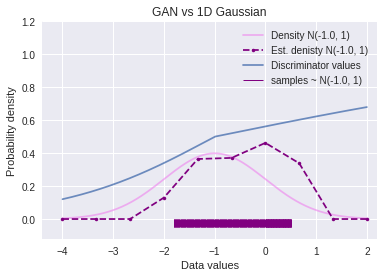

In [11]:
# Before training
fixed_noise = latent.sample(batch_size)
g_sample = G(Tensor(fixed_noise))
d_sample = D(Tensor(np.linspace(-5,5, batch_size).reshape(-1, 1)))

plot_densities(
    dist = g,
    samples = g_sample.detach().numpy(), 
    scores = d_sample.detach().numpy())

0 0.030156437
100 0.010961088
200 0.0041745664
300 0.002713197
400 0.0017281485
500 0.0011504191
600 0.00077264634
700 0.0005614549
800 0.00035988915
900 0.0003028477


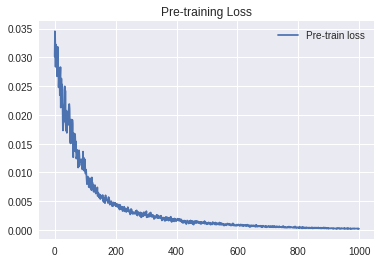

In [12]:
# Pre-training discriminator
num_epochs_pre = 1000

# optimizer
optimizer = torch.optim.Adam(D.parameters(), lr=lr)

# Loss function
pre_criterion = nn.MSELoss()

D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    x = Variable(Tensor(g.sample(batch_size)))
    y = Variable(Tensor(norm.pdf(x, loc=g.mu, scale=g.sigma)))

    # Train model
    optimizer.zero_grad()
    D_pre_decision = D(x)
    D_pre_loss = pre_criterion(D_pre_decision, y)
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.item())

    if epoch % 100 == 0:
        print(epoch, D_pre_loss.data.numpy())
      
# Plot loss
plt.plot(D_pre_losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend();

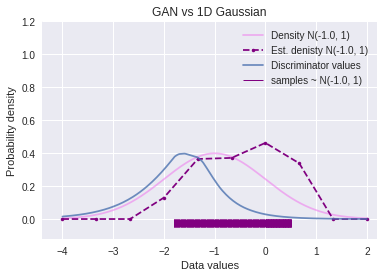

In [13]:
# After pre-training
d_xs = Tensor(np.linspace(-5,5, batch_size).reshape(-1, 1))
d_sample = D(d_xs)

plot_densities(
    dist = g,
    samples = g_sample.detach().numpy(), 
    scores = d_sample.detach().numpy())

0 1.7580485 1.2894403
100 1.4756641 0.69755226
200 1.3615186 0.6965639
300 1.3780477 0.6966305
400 1.4146746 0.71803266
500 1.3664005 0.78830916
600 1.3996537 0.7866708
700 1.421805 0.6951248
800 1.4995601 0.5403971
900 1.9664015 0.34368995
1000 1.3337741 0.8489982
1100 1.3420184 0.63911355
1200 1.323815 0.7251725
1300 1.3309149 0.99519354
1400 1.5382571 0.5503647
1500 1.2586651 0.82252717
1600 1.352757 0.9180231
1700 1.4345878 0.60966426
1800 1.4038036 0.6661928
1900 1.3456411 0.75239563
2000 1.3965576 0.62166226
2100 1.4527433 0.6989584
2200 1.3883691 0.70998275
2300 1.3480039 0.6674388
2400 1.3627702 0.77301437
2500 1.3749211 0.65134966
2600 1.3803407 0.7471271
2700 1.3744849 0.68725
2800 1.3927861 0.7476174
2900 1.4008731 0.66127783


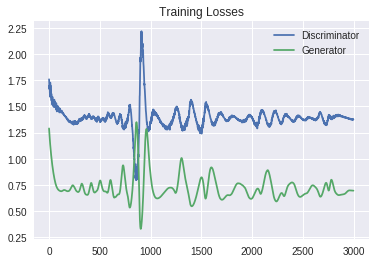

In [14]:
optimizerD = optim.Adam(D.parameters(), lr=lr)
optimizerG = optim.Adam(G.parameters(), lr=lr)


D_losses, G_losses = [], []
anim_frames = []
for epoch in range(num_epochs):
  ############################
  # 1 Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
  ############################
  
  # Zero the gradients
  D.zero_grad()

  # 1.1 Train on real Data
  # Generate batch of real examples
  x = Variable(Tensor(g.sample(batch_size)))
  
  # Forward the batch of reals through Discriminator
  D_real = D(x)
  
  # Calculate D's loss on all-real batch
  D_loss_real = criterion(D_real, target(1, batch_size, device))
  
  # Calculate gradients for D in backward pass
  D_loss_real.backward() 
 
  # 1.2 Train with fake data
  # Generate batch of latent vectors
  z = Variable(Tensor(latent.sample(batch_size)))
  
  # Generate batch of fake numbers and classify it
  # Note: we don't want gradients to flow to G at this point
  g_samples = G(z).detach() 
  D_fake = D(g_samples)
             
  # Calculate D's loss on fake batch
  D_loss_fake = criterion(D_fake, target(0, batch_size, device))
             
  # Calculate gradients for D in backward pass
  D_loss_fake.backward()
  
  # Add the gradients from the all-real and all-fake batches
  D_loss = D_loss_real + D_loss_fake
 
  # Update paramaters of the discriminator
  optimizerD.step()
  
  ############################
  # 2 Train Generator: maximize log(D(G(z)))
  ############################
  # Zero the gradients
  D.zero_grad()
  G.zero_grad()
  
  
  # Generate batch of latent vectors
  z = Variable(Tensor(latent.sample(batch_size)))
  
  # Generate batch of fake numbers and classify it
  # Note: We updated D, perform another forward pass of fake batch through D
  D_fake = D(G(z))  
  
  # Calculate G's loss
  # Note: fake labels are real for generator cost
  G_loss = criterion(D_fake, target(1, batch_size, device))
  
  # Calculate gradients for D in backward pass
  G_loss.backward()
  
  # Update paramaters of the generator
  optimizerG.step()
  
  # Save loss values for plot
  D_losses.append(D_loss.item())
  G_losses.append(G_loss.item())
  
  if epoch % 100 == 0:
    print(epoch, D_loss.data.numpy(), G_loss.data.numpy())
    
  if epoch % epochs_per_frame == 0:
    anim_frames.append(samples(G, D, fixed_noise, g))

# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

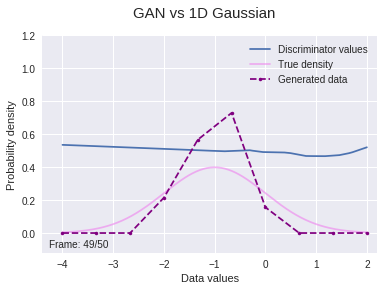

In [16]:
save_animation('training.mp4', anim_frames)